# Spaceship Titanic Competition Notebook

## Data Loading and Preprocessing

In [1]:
import numpy as np
import pandas as pd

# Load the data
df = pd.read_csv('spaceship-titanic/train.csv')
test = pd.read_csv('spaceship-titanic/test.csv')

# Define a function to clean and process the data
def process_df(df):
    # Process CryoSleep and VIP columns
    df['CryoSleep'] = df['CryoSleep'].apply(lambda x: False if pd.isnull(x) else (x.lower() == 'true' if isinstance(x, str) else x))
    df['VIP'] = df['VIP'].apply(lambda x: False if pd.isnull(x) else (x.lower() == 'true' if isinstance(x, str) else x))

    # Fill missing categorical fields
    df['HomePlanet'] = df['HomePlanet'].fillna('Unknown')
    df['Destination'] = df['Destination'].fillna('Unknown')
    df['Name'] = df['Name'].fillna('Unknown')

    # Fill missing numerical values for Age with the median of the dataset
    df['Age'] = df['Age'].fillna(df['Age'].median())
    for col in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
        df[col] = df[col].fillna(0)

    # Process Cabin: fill missing values and split into three parts
    df['Cabin'] = df['Cabin'].fillna("Unknown/0/Unknown")
    df['CabinDeck'] = df['Cabin'].str.split('/').str[0].astype('category')
    df['CabinNum'] = df['Cabin'].str.split('/').str[1].astype('category')
    df['CabinSide'] = df['Cabin'].str.split('/').str[2].astype('category')
    df.drop('Cabin', axis=1, inplace=True)

    # Adjusted TotalSpending: weighted to reflect correlation with target
    df['TotalSpending'] = (
        + df['FoodCourt'] 
        + df['ShoppingMall'] 
        + df['RoomService'] 
        - df['Spa'] 
        - df['VRDeck']
    )
    # Extract group information from PassengerId
    df['Group'] = df['PassengerId'].str.split('_').str[0].astype('category')
    df['NumberInGroup'] = df['PassengerId'].str.split('_').str[1].astype('category')

    # Add new feature: TravelingAlone
    group_counts = df['Group'].value_counts()
    df['TravelingAlone'] = df['Group'].map(group_counts) == 1

    # Drop unneeded columns
    df = df.drop(columns=['PassengerId', 'Name'])

    return df

# Process both training and test datasets
df = process_df(df)
test = process_df(test)

df['HomePlanet'] = df['HomePlanet'].astype('category')
df['CryoSleep'] = df['CryoSleep'].astype('category')
df['Destination'] = df['Destination'].astype('category')
df['VIP'] = df['VIP'].astype('category')
df['TravelingAlone'] = df['TravelingAlone'].astype('category')

/Users/lingyizhao/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Explanatory Data Analysis

First we analyze the correlation of all the vairables, and explore the data.

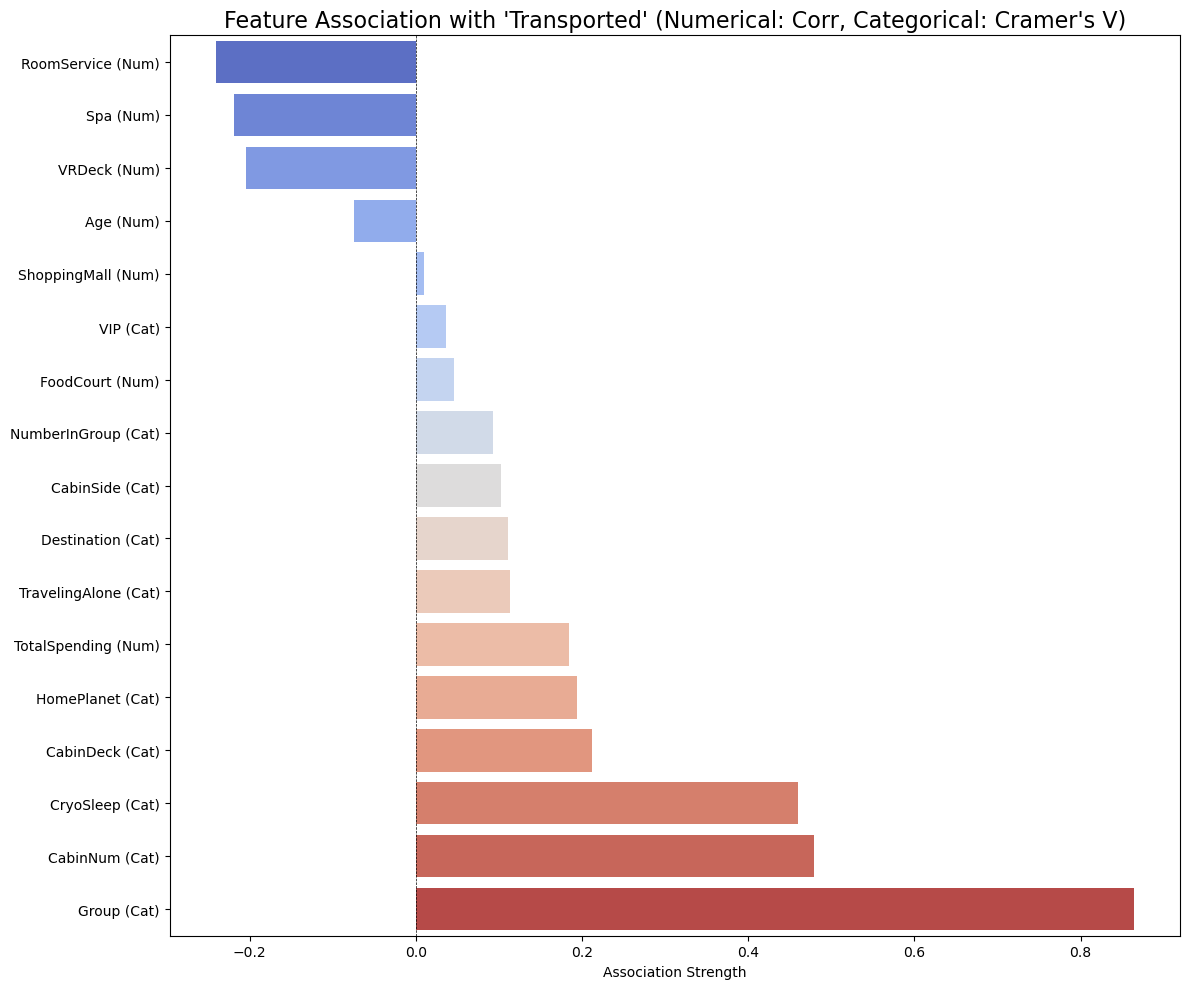

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# Define columns
num_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','TotalSpending']
cat_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Group', 'NumberInGroup', 'CabinDeck', 'CabinNum', 'CabinSide', 'TravelingAlone']

# Numerical correlation with 'Transported'
num_corr = df[num_features + ['Transported']].corr()['Transported'].drop('Transported')
num_corr.index = [f"{col} (Num)" for col in num_corr.index]

# Categorical: Cramer's V with 'Transported'
def cramers_v(col):
    contingency = pd.crosstab(df[col], df['Transported'])
    chi2, _, _, _ = chi2_contingency(contingency)
    n = contingency.sum().sum()
    return np.sqrt(chi2 / (n * (min(contingency.shape) - 1)))

cat_cramers_v = pd.Series({col: cramers_v(col) for col in cat_features})
cat_cramers_v.index = [f"{col} (Cat)" for col in cat_cramers_v.index]

# Combine and sort
combined_assoc = pd.concat([num_corr, cat_cramers_v]).sort_values()

# Plot
plt.figure(figsize=(12, 10))
sns.barplot(x=combined_assoc.values, y=combined_assoc.index, palette="coolwarm")
plt.title("Feature Association with 'Transported' (Numerical: Corr, Categorical: Cramer's V)", fontsize=16)
plt.xlabel("Association Strength")
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

#Drop no need columns
df.drop(columns=['FoodCourt', 'ShoppingMall', 'RoomService', 'Spa', 'VRDeck'], inplace=True)

In [3]:
print("Unique CabinNum values:", df['CabinNum'].nunique())
print("Unique Group values:", df['Group'].nunique())
print("CabinNum value counts:")
print(df['CabinNum'].value_counts())

print("\nGroup value counts:")
print(df['Group'].value_counts())

# Group and CabinNum show unusually high Cramer's V with Transported, but this is likely misleading.
# These variables have very high cardinality (6217 unique Groups and 1817 CabinNums), which can inflate correlation metrics.
# Their strong statistical correlation doesn’t reflect meaningful information, as both seem arbitrary and don’t logically relate to the target.
# This is a known issue where high-cardinality categorical features create near one-to-one mappings with the outcome, distorting correlation measures.

Unique CabinNum values: 1817
Unique Group values: 6217
CabinNum value counts:
CabinNum
0       217
82       28
86       22
19       22
97       21
       ... 
1685      1
639       1
1082      1
1689      1
1877      1
Name: count, Length: 1817, dtype: int64

Group value counts:
Group
4498    8
8168    8
8728    8
8796    8
8956    8
       ..
3483    1
3480    1
3478    1
3473    1
4620    1
Name: count, Length: 6217, dtype: int64


/Users/lingyizhao/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


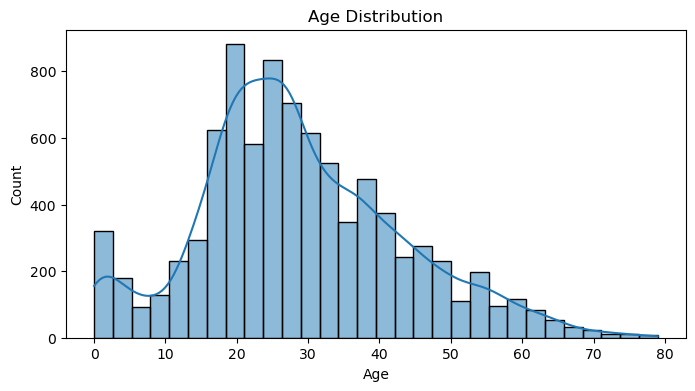

/Users/lingyizhao/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


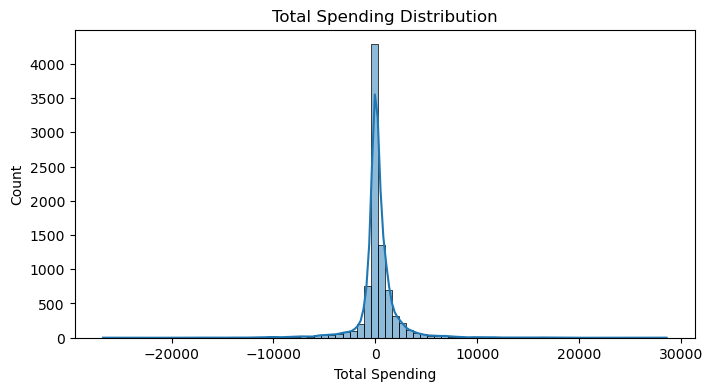

/Users/lingyizhao/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/lingyizhao/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


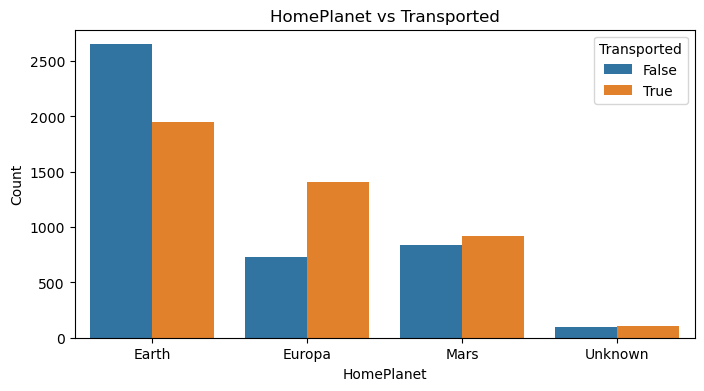

In [4]:
# Distribution of Age
plt.figure(figsize=(8, 4))
sns.histplot(df['Age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Distribution of Total Spending
plt.figure(figsize=(8, 4))
sns.histplot(df['TotalSpending'], bins=80, kde=True)
plt.title('Total Spending Distribution')
plt.xlabel('Total Spending')
plt.ylabel('Count')
plt.show()

# Count of HomePlanet by Transported status
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='HomePlanet', hue='Transported')
plt.title('HomePlanet vs Transported')
plt.xlabel('HomePlanet')
plt.ylabel('Count')
plt.show()

## Feature Engineering and Preprocessing

We now define our features and set up a preprocessing pipeline. We separate numeric and categorical features. For numeric features, we apply a power transformation to reduce skewness and scale them. For categorical features, we impute missing values and one-hot encode them.

In [7]:
df_X.dtypes

HomePlanet        category
CryoSleep         category
Destination       category
Age                float64
VIP               category
CabinDeck         category
CabinNum          category
CabinSide         category
TotalSpending      float64
Group             category
NumberInGroup        int64
TravelingAlone    category
dtype: object

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer

# Prepare training data features and target
df_X = df.drop(['Transported'], axis=1)
y = df['Transported'].astype(int)
df_X['NumberInGroup'] = pd.to_numeric(df_X['NumberInGroup'], errors='coerce')
# Define features lists
numeric_features = ['Age', 'TotalSpending', 'NumberInGroup']
categorical_features = ['HomePlanet','CryoSleep','Destination','VIP','CabinDeck','CabinNum','CabinSide','Group','TravelingAlone']

numeric_features = [col for col in numeric_features if col in df_X.columns]
categorical_features = [col for col in categorical_features if col in df_X.columns]
numeric_features
categorical_features

['HomePlanet',
 'CryoSleep',
 'Destination',
 'VIP',
 'CabinDeck',
 'CabinNum',
 'CabinSide',
 'Group',
 'TravelingAlone']

In [14]:
for col in numeric_features:
    df_X[col] = pd.to_numeric(df_X[col], errors='coerce')

In [15]:
# Clean numeric pipeline
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  
    ('power', PowerTransformer(method='yeo-johnson', standardize=False)),
    ('scaler', StandardScaler())
])

# Clean categorical pipeline
#categorical_transformer = Pipeline([
#    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
#    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
#])


In [22]:
df_X[categorical_features] = df_X[categorical_features].astype(str).fillna('Missing')
df_X_encoded = pd.get_dummies(df_X, columns=categorical_features, drop_first=False)
df_X_encoded

,Age,TotalSpending,NumberInGroup,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_Unknown,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,...,Group_9270,Group_9272,Group_9274,Group_9275,Group_9276,Group_9278,Group_9279,Group_9280,TravelingAlone_False,TravelingAlone_True
0,39.0,0.0,1,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
1,24.0,-450.0,1,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
2,58.0,-3145.0,1,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
3,33.0,-1868.0,2,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
4,16.0,-43.0,1,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,41.0,5102.0,1,False,True,False,False,True,False,True,...,False,False,False,False,True,False,False,False,False,True
8689,18.0,0.0,1,True,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,True
8690,26.0,1871.0,1,True,False,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,True
8691,32.0,-2539.0,1,False,True,False,False,True,False,True,...,False,False,False,False,False,False,False,True,True,False


In [23]:
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features)
])


## Modeling: Logistic Regression and Random Forest 

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, C=1.0, random_state=42))
])

# ---- Train/Validation Split and Model Evaluation ----
# Stratify by target to keep distribution balanced.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Fit the pipeline on the training data.
pipeline.fit(X_train, y_train)

# Predict on validation data and calculate accuracy.
y_pred = pipeline.predict(X_val)
val_accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Cross-validation for a robust performance estimate.
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}')

NameError: name 'X' is not defined

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Build a new pipeline using RandomForestClassifier
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Let's evaluate our RandomForest model with 5-fold cross-validation.
rf_cv_scores = cross_val_score(rf_pipeline, X, y, cv=5, scoring='accuracy')
print(f'Random Forest Cross-Validation Accuracy: {np.mean(rf_cv_scores):.4f} ± {np.std(rf_cv_scores):.4f}')

# Optionally, perform hyperparameter tuning using GridSearchCV
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best CV Accuracy: {grid_search.best_score_:.4f}')

# Evaluate the best estimator on the validation set.
best_rf_model = grid_search.best_estimator_
y_pred_rf = best_rf_model.predict(X_val)
rf_val_accuracy = accuracy_score(y_val, y_pred_rf)
print(f'Random Forest Validation Accuracy: {rf_val_accuracy:.4f}')

Random Forest Cross-Validation Accuracy: 0.7791 ± 0.0094
Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Best CV Accuracy: 0.7998
Random Forest Validation Accuracy: 0.8068


## Modeling with XGBoost

In [25]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

for col in df_X.columns:
    print(col, df_X[col].dtype)

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 6, 10],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1]
}

xgb_grid = GridSearchCV(xgb_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1,error_score='raise')
xgb_grid.fit(df_X, y)
best_xgb = xgb_grid.best_estimator_
print("Best XGBoost parameters:", xgb_grid.best_params_)

HomePlanet object
CryoSleep object
Destination object
Age float64
VIP object
CabinDeck object
CabinNum object
CabinSide object
TotalSpending float64
Group object
NumberInGroup int64
TravelingAlone object


/Users/lingyizhao/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/lingyizhao/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/lingyizhao/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/lingyizhao/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/lingyizhao/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: Us

Best XGBoost parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}


/Users/lingyizhao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [04:27:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [26]:
xgb_grid.best_params_

{'classifier__learning_rate': 0.1,
 'classifier__max_depth': 3,
 'classifier__n_estimators': 100,
 'classifier__subsample': 0.8}

In [29]:
from sklearn.metrics import accuracy_score
xgb_best_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        learning_rate=0.1,
        max_depth=3,
        n_estimators=100,
        subsample=0.8,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ))
])
xgb_best_pipeline.fit(df_X, y)
y_pred = xgb_best_pipeline.predict(df_X)
accuracy = accuracy_score(y, y_pred)
print(f"XGB Boost Accuracy: {accuracy:.4f}")

XGB Boost Accuracy: 0.7574


/Users/lingyizhao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [04:32:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## Test Data Prediction and Submission

In [ ]:
X_test = test.drop(['PassengerId', 'Name', 'GroupID'], axis=1)
test_preds = best_xgb.predict(X_test)
test_preds_str = ['True' if p == 1 else 'False' for p in test_preds]
submission = pd.DataFrame({'PassengerId': test['PassengerId'], 'Transported': test_preds_str})
submission.to_csv('submission.csv', index=False)

# Conclusion